# Unsupervised learning

We will use *scikit-learn* more extensively in this notebook.

Scikit-learn is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities.

Let's make sure we have the latest version installed

In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Outlier detection

Outlier (or anomaly) detection deals with finding data points that are "different" from what "expected".

Outlier/anomaly detection is typically an unsupervised task and thus is highly related to cluster analysis. Clustering looks for patterns in data whereas anomaly **detection** aims at **identifying** the data **points** that deviate from such **patterns**.

Let's first generate a simple working example

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(font_scale=1.2, rc={"figure.figsize": (8, 6)})

from sklearn import datasets


def generate_anomaly_samples(n_clusters=1, n_samples=200, n_outliers=20, seed=42, scale=0.1):
    """
    Generate samples from multivariate normal distributions (inliers) and from a uniform distribution (outliers) for anomaly detection.

    Parameters
    ----------
    n_clusters : int, default=1
        The number of clusters. Each cluster represents an inlier class.
    n_samples : int, default=200
        The total number of samples to generate per cluster.
    n_outliers : int, default=20
        The number of outlier samples to generate.
    seed : int, default=42
        Seed value for random number generation.
    scale : float, default=0.1
        Scaling factor for the covariance matrices.

    Returns
    -------
    X : ndarray of shape (n_samples*n_clusters + n_outliers, 2)
        An array containing the generated samples.
    y : ndarray of shape (n_samples*n_clusters + n_outliers,)
        An array containing the class labels, where inlier samples are labeled as 1 and outlier samples are labeled as -1.
    """
    rng = np.random.default_rng(seed)
    if n_clusters == 1:
        cluster_1 = rng.multivariate_normal(mean=np.array([0, 0]), cov=scale * np.identity(2), size=n_samples)
        outliers = rng.uniform(low=-2, high=2, size=(n_outliers, 2))
        X = np.concatenate([cluster_1, outliers])
    else:
        covariance = np.array([[1.2, 0.5], [0.5, 0.7]])
        cluster_1 = rng.multivariate_normal(mean=np.array([2, 2]), cov=scale * covariance, size=n_samples)
        cluster_2 = rng.multivariate_normal(mean=np.array([-2, -2]), cov=scale * np.identity(2), size=n_samples)
        outliers = rng.uniform(low=-4, high=4, size=(n_outliers, 2))
        X = np.concatenate([cluster_1, cluster_2, outliers])
    
    y = np.concatenate(
        [np.ones((n_samples * n_clusters), dtype=int), -np.ones((n_outliers), dtype=int)]
    )

    return X, y

In [ ]:
X, y = generate_anomaly_samples()
df_outlier_det = pd.DataFrame(data=X, columns=["feature_1", "feature_2"])
df_outlier_det["class"] = np.where(y == 1, "inliers", "outliers")
df_outlier_det.head(5)

,feature_1,feature_2,class
0,0.096360,-0.328872,inliers
1,0.237314,0.297433,inliers
2,-0.616971,-0.411785,inliers
3,0.040427,-0.100005,inliers
4,-0.005313,-0.269756,inliers


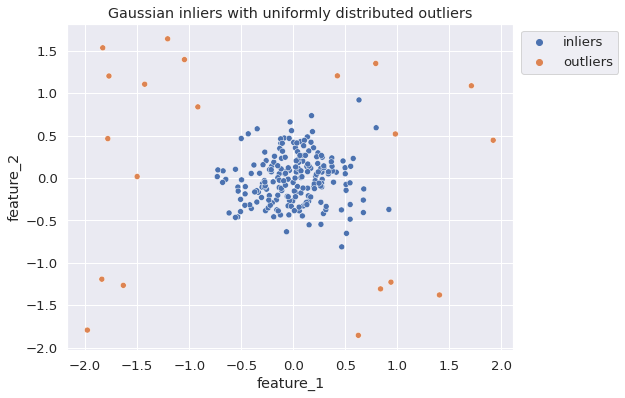

In [ ]:
ax = sns.scatterplot(
    data=df_outlier_det,
    x="feature_1",
    y="feature_2",
    hue="class"
  )
ax.set_title("Gaussian inliers with uniformly distributed outliers")
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.))

### Standard deviation method

The simplest way to identify outliers is to analyze each variable separately using simple statistics, like for example the standard deviation.

If we assume that the variables were drawn from the **same** normal distribution, we can label as outliers the points lying outside 2$\sigma$ or 3$\sigma$

In [ ]:
df_outlier_det.describe().loc[["mean", "std"]]

,feature_1,feature_2
mean,-0.026832,0.003414
std,0.518815,0.463612


In [ ]:
print(f"Number of true outliers: {np.sum(y == -1)}", end="\n\n")

for col in ("feature_1", "feature_2"):
    mean, std = df_outlier_det[col].mean(), df_outlier_det[col].std()
    lower = mean - 3 * std
    upper = mean + 3 * std
    outliers_pos = (df_outlier_det[col] < lower) | (df_outlier_det[col] > upper)
    print(f"Number of outliers in {col}: {np.sum(outliers_pos)}")
    print(df_outlier_det.loc[outliers_pos, col], end="\n\n")

Number of true outliers: 20

Number of outliers in feature_1: 8
203   -1.978281
206   -1.771072
207    1.711182
209   -1.839395
215    1.920819
216   -1.781999
217   -1.830598
219   -1.633116
Name: feature_1, dtype: float64

Number of outliers in feature_2: 5
201    1.642553
202   -1.855349
203   -1.793368
205    1.397635
217    1.536583
Name: feature_2, dtype: float64



This method can fail to detect outliers because the **outliers** increase the **standard deviation**. The more extreme the outlier, the more the standard deviation is affected.

Moreover, in case of samples drawn from a more complicated distribution, the standard deviation method would not give meaningful results.

### Isolation forest

Let's generate some toy data

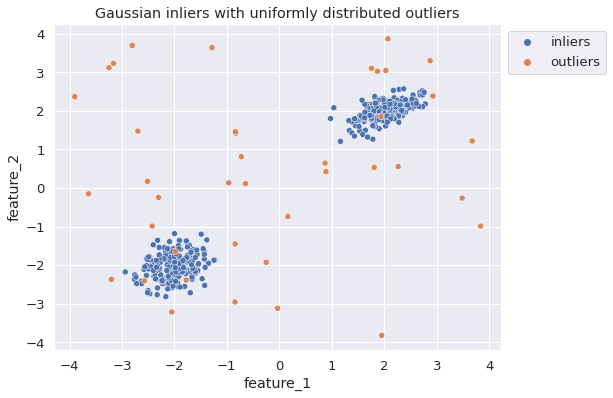

In [ ]:
X, y = generate_anomaly_samples(n_clusters=2, n_outliers=40)
df_outlier_det = pd.DataFrame(data=X, columns=["feature_1", "feature_2"])
df_outlier_det["class"] = np.where(y == 1, "inliers", "outliers")

ax = sns.scatterplot(
    data=df_outlier_det,
    x="feature_1",
    y="feature_2",
    hue="class"
  )

ax.set_title("Gaussian inliers with uniformly distributed outliers")
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.))

The Isolation Forest algorithm identifies anomalies by computing the number of random splits required to isolate a single data point.

Outliers are usually easier to isolate with fewer splits because they have some feature value that distinguish them from the more typical data points (the inliers).

The `IsolationForest` *predictor* of scikit-learn provides an implementation of this algorithm

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=150, random_state=42)
y_pred = clf.fit_predict(X)

The `fit_predict()` method is a convenient combination of the following two operations:

1.   `fit()`: fits the estimator
2.   `predict()`: predicts if a particular sample is an outlier or not

This pattern (`fit/predict`) is the same for each *predictor* of the scikit-learn library.

We can check the number of missclassified samples

In [ ]:
print(f"Number of missclassified samples: {np.sum(y_pred != y)}")

Number of missclassified samples: 41


In a real world scenario we would not know which are the outliers. We could run the `IsolationForest` using different values for `contamination` (i.e., the threshold applied to decide whether a point is an outlier)

In [ ]:
for contamination in (0.01, 0.05, 0.1, 0.2):
    y_pred = IsolationForest(
        max_samples=150,
        contamination=contamination,
        random_state=42
    ).fit_predict(X)
    print(f"Contamination: {contamination}. Number of missclassified samples: {np.sum(y_pred != y)}")

Contamination: 0.01. Number of missclassified samples: 35
Contamination: 0.05. Number of missclassified samples: 18
Contamination: 0.1. Number of missclassified samples: 12
Contamination: 0.2. Number of missclassified samples: 54


Scikit-learn has a useful class, `DecisionBoundaryDisplay`, to display the decision boundaries of fitted predictors

Text(0.5, 1.0, 'Binary decision boundary of IsolationForest')

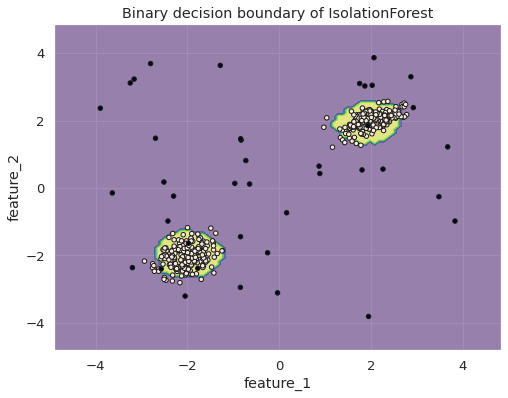

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

clf = IsolationForest(max_samples=150, random_state=42).fit(X)

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    alpha=0.5,
    xlabel="feature_1",
    ylabel="feature_2",
    cmap="viridis"
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary of IsolationForest")

## Clustering

Clustering algorithms allow to identify **patterns** in data by classifying "similar" samples into the same **group** (a cluster).

We will see two clustering algorithms: K-means and Hierarchical clustering.

### K-means

Let's create a toy dataset

Text(0.5, 1.0, 'Blobs dataset')

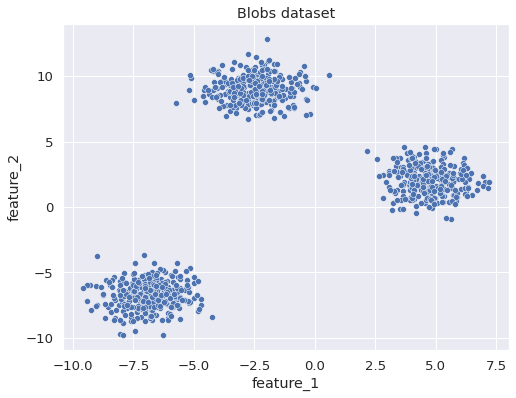

In [ ]:
X_blobs, _ = datasets.make_blobs(n_samples=1000, centers=3, random_state=42)
df_blobs = pd.DataFrame(X_blobs, columns=["feature_1", "feature_2"])

sns.scatterplot(
    data=df_blobs,
    x="feature_1",
    y="feature_2"
).set_title("Blobs dataset")

Scikit-learn provides the K-means algorithm implementation with the `KMeans` *predictor*

Text(0.5, 1.0, 'K-means : n_clusters = 3')

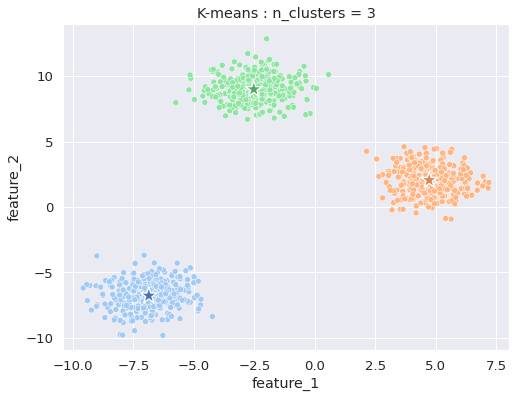

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init="auto", random_state=42)
y_pred = kmeans.fit_predict(df_blobs)

# Plot clusters
sns.scatterplot(
    data=df_blobs,
    x="feature_1",
    y="feature_2",
    hue=y_pred,
    palette="pastel",
    legend=False
  )

# Plot predicted cluster centers
sns.scatterplot(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    marker="*",
    s=300,
    c=sns.color_palette(palette="deep", n_colors=3)
  ).set_title("K-means : n_clusters = 3")

There is no uniquely defined **true** number of clusters. An appropriate number of clusters has to be decided from data-based criteria and knowledge of the intended goal

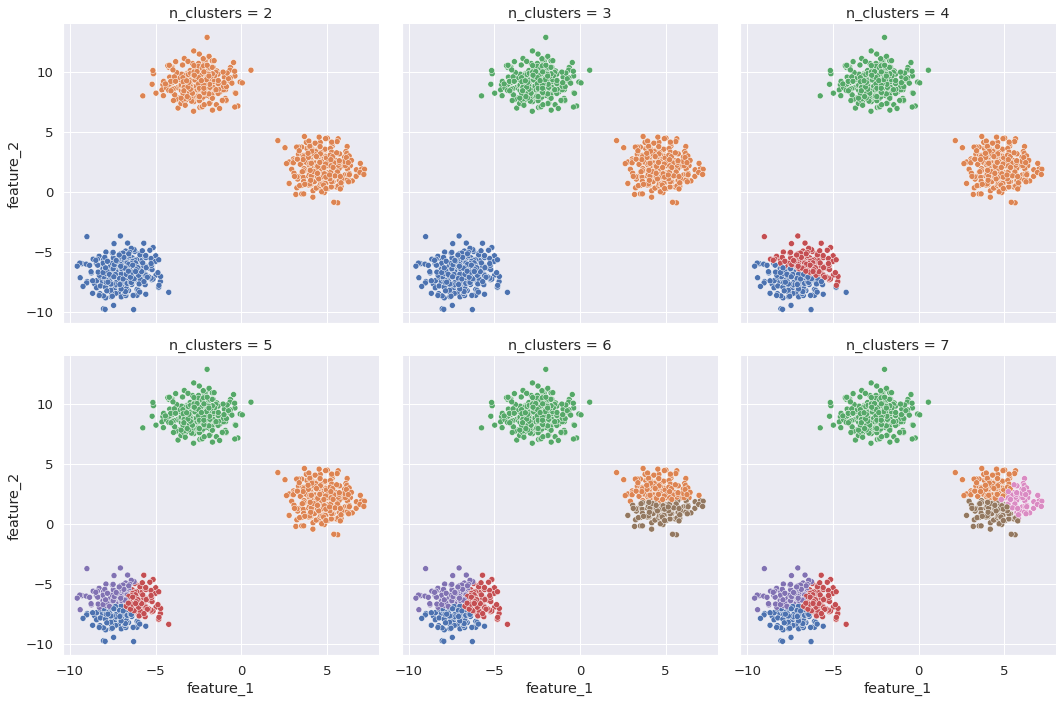

In [ ]:
df_blobs_pred = df_blobs.copy()

for n_clusters in range(2, 8):
    y_pred = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42).fit_predict(X_blobs)
    df_blobs_pred[n_clusters] = y_pred

sns.relplot(
    data=df_blobs_pred.melt(
        id_vars=df_blobs_pred.columns[:2],
        var_name="n_clusters",
        value_name="pred class"
      ),
    x="feature_1",
    y="feature_2",
    hue="pred class",
    col="n_clusters",
    col_wrap=3,
    palette="deep",
    legend=False
  )

#### K-means limitations

A strong **assumption** of **K-means** clustering is that clusters are assumed to be isotropic (spherical gaussians), which is not always the case.

Therefore, **KMeans** can perform poorly when clusters have unequal variance or size, even when data was drawn from gaussian distributions

Text(0.5, 1.0, 'Blobs with unequal size and variance')

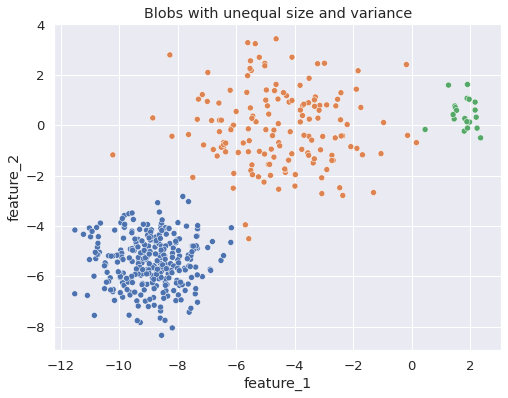

In [ ]:
# Make blobs with unequal variance
X_unequal, y_unequal = datasets.make_blobs(
    n_samples=1000,
    cluster_std=[1.0, 1.75, 0.5],
    random_state=170
  )

# Keep a different fraction of samples for each blob
X_unequal = np.vstack(
    (X_unequal[y_unequal == 0][:300],
     X_unequal[y_unequal == 1][:150],
     X_unequal[y_unequal == 2][:20])
  )
y_unequal = [0] * 300 + [1] * 150 + [2] * 20

df_unequal = pd.DataFrame(X_unequal, columns=["feature_1", "feature_2"])

sns.scatterplot(
    data=df_unequal,
    x="feature_1",
    y="feature_2",
    hue=y_unequal,
    palette="deep",
    legend=False
  ).set_title("Blobs with unequal size and variance")

Text(0.5, 1.0, 'K-means : n_clusters = 3, unequal size and variance')

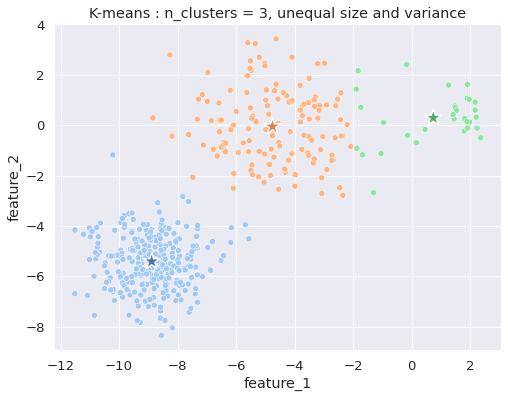

In [ ]:
kmeans = KMeans(n_clusters=3, n_init="auto", random_state=42)
y_pred = kmeans.fit_predict(df_unequal)

sns.scatterplot(
    data=df_unequal,
    x="feature_1",
    y="feature_2",
    hue=y_pred,
    palette="pastel",
    legend=False
  )
sns.scatterplot(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    marker="*",
    s=300,
    c=sns.color_palette(palette="deep", n_colors=3)
  ).set_title("K-means : n_clusters = 3, unequal size and variance")


Finally, **KMeans** struggles separating elongated clusters or irregular shapes.

Try predicting the clusters of this toy data using `KMeans`

Text(0.5, 1.0, 'Moons dataset')

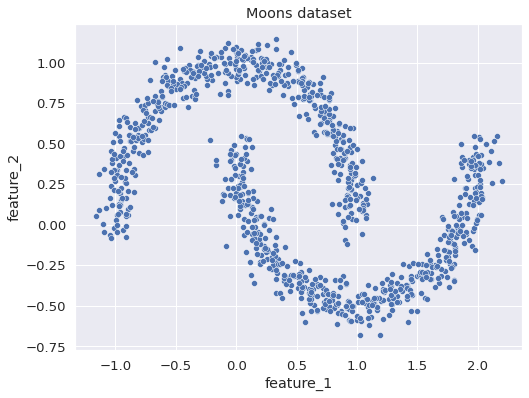

In [ ]:
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=0.075, random_state=42)

df_moons = pd.DataFrame(data=X_moons, columns=["feature_1", "feature_2"])

sns.scatterplot(
    data=df_moons,
    x="feature_1",
    y="feature_2",
  ).set_title("Moons dataset")

Text(0.5, 1.0, 'K-means : n_clusters = 2')

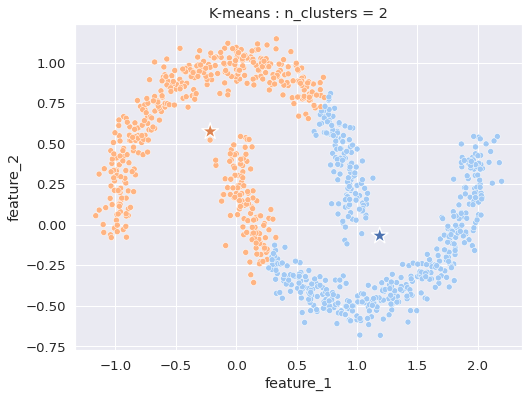

In [ ]:
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
y_pred = kmeans.fit_predict(df_moons)

# Plot clusters
sns.scatterplot(
    data=df_moons,
    x="feature_1",
    y="feature_2",
    hue=y_pred,
    palette="pastel",
    legend=False
  )

# Plot predicted cluster centers
sns.scatterplot(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    marker="*",
    s=300,
    c=sns.color_palette(palette="deep", n_colors=2)
  ).set_title("K-means : n_clusters = 2")

### Hierarchical clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively.

With scikit-learn, the `AgglomerativeClustering` *predictor* performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together.

Let's predict the clusters for the three toy datasets we used (blobs, unequal size/variance blobs, and moons), using `AgglomerativeClustering`

In [ ]:
from sklearn.cluster import AgglomerativeClustering

df_hierarchical_pred = pd.DataFrame()

for df, dataset, n_clusters in [(df_blobs, "blobs", 3),
                                (df_unequal, "unequal", 3),
                                (df_moons, "moons", 2)]:
    df_copy = df.copy()
    y_pred = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(df_copy)
    df_copy["dataset"] = dataset
    df_copy["pred class"] = y_pred
    df_hierarchical_pred = pd.concat((df_hierarchical_pred, df_copy), axis=0)

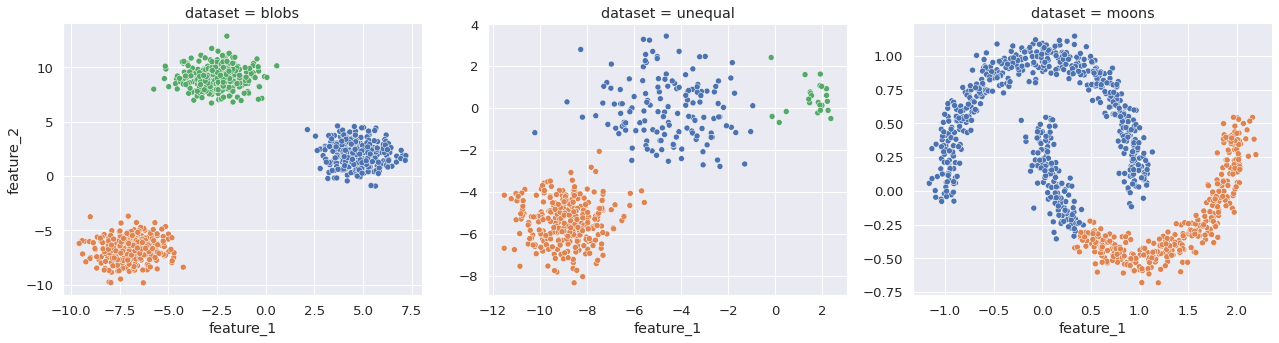

In [ ]:
sns.relplot(
    data=df_hierarchical_pred,
    x="feature_1",
    y="feature_2",
    hue="pred class",
    col="dataset",
    legend=False,
    palette="deep",
    facet_kws={"sharex": False, "sharey": False},
    aspect=1.2
)

`AgglomerativeClustering` performed slightly better than **KMeans** on the uneven dataset, while similarly on the moons dataset.

The `linkage` hyperparameter can be tuned to change the clustering criteria. For example, with `linkage = "single"`, the algorithm will cluster data by considering the **minimum distance** between all observations of two sets

Text(0.5, 1.0, 'Agglom. clutering : n_clusters = 2, linkage="single"')

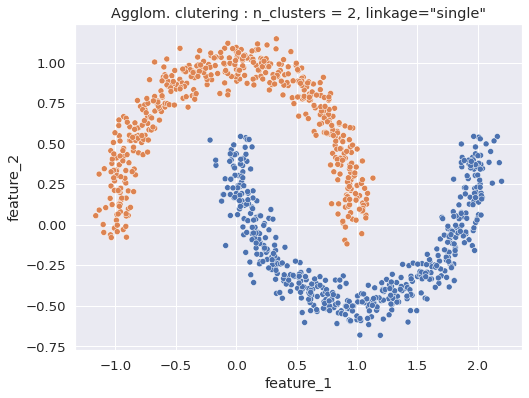

In [ ]:
y_pred = AgglomerativeClustering(n_clusters=2, linkage="single").fit_predict(df_moons)

sns.scatterplot(
    data=df_moons,
    x="feature_1",
    y="feature_2",
    hue=y_pred,
    legend=False,
    palette="deep"
).set_title("Agglom. clutering : n_clusters = 2, linkage=\"single\"")

Try using different `linkage` values on the three datasets and see how they might affect the resulting clustering

In [ ]:
from itertools import product

df_hierarchical_pred_linkage = pd.DataFrame()

for (df, dataset, n_clusters), linkage in product(
    [(df_blobs, "blobs", 3), (df_unequal, "unequal", 3), (df_moons, "moons", 2)],
    ("single", "average", "complete", "ward")
):
    df_copy = df.copy()
    y_pred = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit_predict(df_copy)
    df_copy["dataset"] = dataset
    df_copy["linkage"] = linkage
    df_copy["pred class"] = y_pred
    df_hierarchical_pred_linkage = pd.concat((df_hierarchical_pred_linkage, df_copy), axis=0)

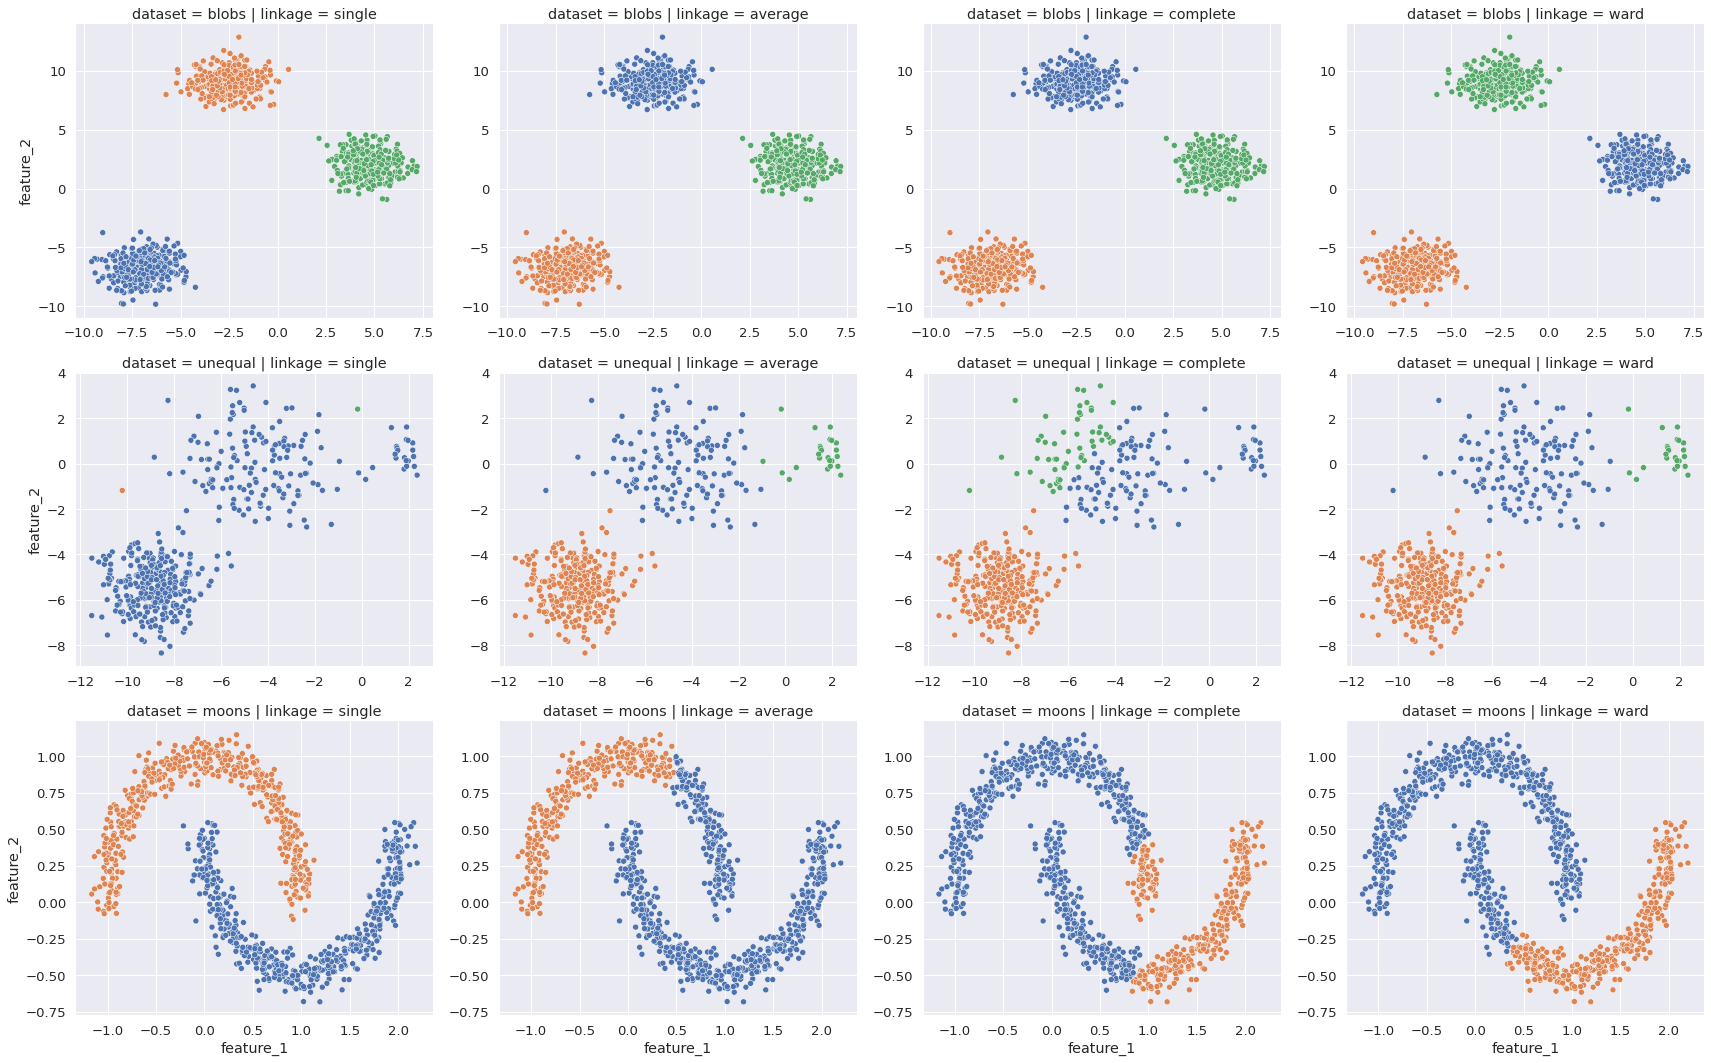

In [ ]:
sns.relplot(
    data=df_hierarchical_pred_linkage,
    x="feature_1",
    y="feature_2",
    hue="pred class",
    col="linkage",
    row="dataset",
    legend=False,
    palette="deep",
    facet_kws={"sharex": False, "sharey": False},
    aspect=1.2
)

Note:

*   single linkage can perform well on non-globular data, but it performs poorly in the presence of noise
*   average and complete linkage perform well on cleanly separated globular clusters, but have mixed results otherwise
*   Ward is the most effective method for noisy data

#### Cluster hierarchy visualization

It’s possible to **visualize** the tree representing the hierarchical **merging** of clusters as a **dendrogram**.

Visual inspection can often be useful for understanding the structure of the data, though more so in the case of small sample sizes.

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt


def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram based on the hierarchical clustering model `model`.

    Parameters
    ----------
    model : sklearn.cluster.AgglomerativeClustering object
        The hierarchical clustering model to plot. This object should have been fitted to some data beforehand.

    **kwargs : optional keyword arguments
        Additional keyword arguments to pass to the `scipy.cluster.hierarchy.dendrogram` function. See the documentation of that function for details.

    Returns
    -------
    None
        This function only produces a plot, it does not return anything.

    Notes
    -----
    The dendrogram shows the hierarchical relationships between clusters computed by the model.
    The vertical axis represents the distance between clusters, and the horizontal axis represents the individual samples or clusters.
    """
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

To visualize the dendrogram, you need the compute the complete tree structure (i.e., generating all possible clusters)

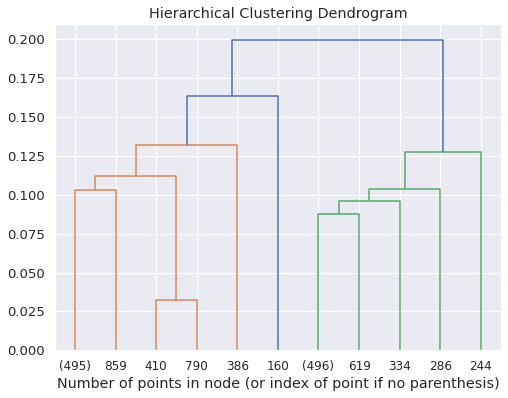

In [ ]:
clf = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=0).fit(df_moons)
plot_dendrogram(clf, truncate_mode="level", p=4)

With seaborn, you can visualize a tabular dataset as a hierarchically-clustered heatmap using `clustermap()`.

For example, using the *moons* dataset

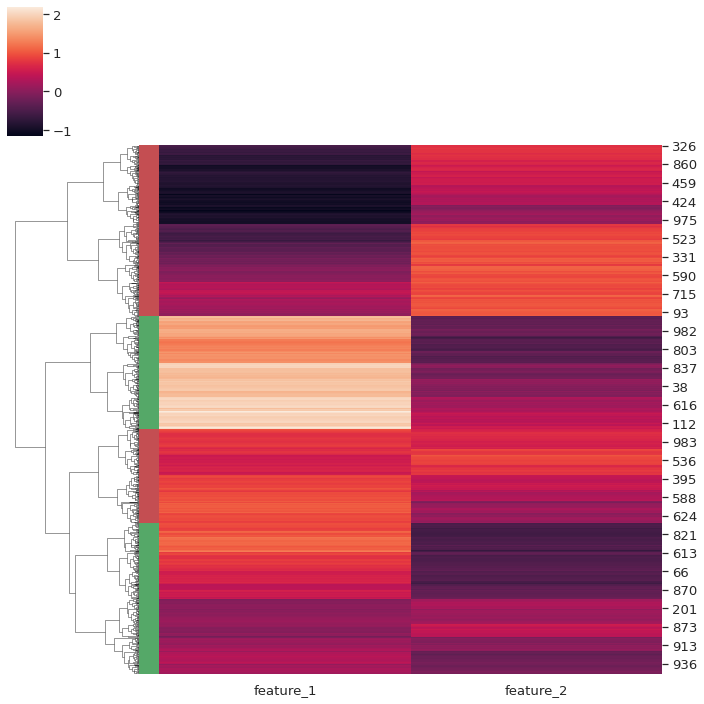

In [ ]:
row_colors = np.where(y_moons == 0, "r", "g")
sns.clustermap(df_moons, col_cluster=False, row_colors=row_colors)  # by default generates clusters with linkage="average"

# References

1.   Scikit-learn `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
2.   Scikit-learn `IsolationForest`: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
3.   Scikit-learn `DecisionBoundaryDisplay`: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html
4.   Scikit-learn `KMeans`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
5.   Scikit-learn `AgglomerativeClustering`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
6.   SciPy dendrogram: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
7.   Seaborn `clustermap`: https://seaborn.pydata.org/generated/seaborn.clustermap.html
8.   pandas `map`: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html